In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import networkx as nx
from itertools import combinations

In [2]:
df = pd.read_csv('data/Merged_tmdb_data.csv')

df.info(),df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   movie_id                     4803 non-null   int64  
 1   title_x                      4803 non-null   object 
 2   cast                         4803 non-null   object 
 3   crew                         4803 non-null   object 
 4   Adjusted_Cast                4803 non-null   object 
 5   Cast_Size                    4803 non-null   int64  
 6   Top_Cast                     4803 non-null   object 
 7   Cast_Gender_Ratio            4803 non-null   object 
 8   Adjusted_Crew                4803 non-null   object 
 9   Crew_Size                    4803 non-null   int64  
 10  Crew_Dept_Cout               4803 non-null   object 
 11  Crew_Gender_Ratio            4803 non-null   object 
 12  Cast_Crew_Ratio              4775 non-null   float64
 13  budget            

(None,
    movie_id                                   title_x  \
 0     19995                                    Avatar   
 1       285  Pirates of the Caribbean: At World's End   
 2    206647                                   Spectre   
 3     49026                     The Dark Knight Rises   
 4     49529                               John Carter   
 
                                                 cast  \
 0  [{'cast_id': 242, 'character': 'Jake Sully', '...   
 1  [{'cast_id': 4, 'character': 'Captain Jack Spa...   
 2  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
 3  [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
 4  [{'cast_id': 5, 'character': 'John Carter', 'c...   
 
                                                 crew  \
 0  [{'credit_id': '52fe48009251416c750aca23', 'de...   
 1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...   
 2  [{'credit_id': '54805967c3a36829b5002c41', 'de...   
 3  [{'credit_id': '52fe4781c3a36847f81398c3', 'de...   
 4  [{'credit_

In [3]:
#Handle Missing Values
# Step 1: Check for missing values
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_summary / len(df)) * 100

# Combine both into a DataFrame for easier visualization
missing_data = pd.DataFrame({'Missing Values': missing_summary, 'Percentage (%)': missing_percentage})
print(missing_data)

# Step 2: Handle missing values
# Example: Drop columns with >50% missing values
threshold = 50
columns_to_drop = missing_data[missing_data['Percentage (%)'] > threshold].index
df_cleaned = df.drop(columns=columns_to_drop)

# Example: Fill numerical missing values with the mean
numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
df_cleaned[numerical_columns] = df_cleaned[numerical_columns].fillna(df_cleaned[numerical_columns].mean())

# Example: Fill categorical missing values with 'Unknown'
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna('Unknown')

# Display the updated dataset info
df_cleaned.info()


                             Missing Values  Percentage (%)
homepage                               3091       64.355611
tagline                                 844       17.572351
Cast_Crew_Ratio                          28        0.582969
overview                                  3        0.062461
runtime                                   2        0.041641
release_date                              1        0.020820
movie_id                                  0        0.000000
production_companies                      0        0.000000
production_countries                      0        0.000000
revenue                                   0        0.000000
status                                    0        0.000000
spoken_languages                          0        0.000000
title_y                                   0        0.000000
vote_average                              0        0.000000
vote_count                                0        0.000000
Adjusted_Production_Company             

In [4]:
def safe_parse(column):
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df['Top_Cast'] = safe_parse(df['Top_Cast'])
df['Adjusted_Cast'] = safe_parse(df['Adjusted_Cast'])
df['Adjusted_Crew'] = safe_parse(df['Adjusted_Crew'])

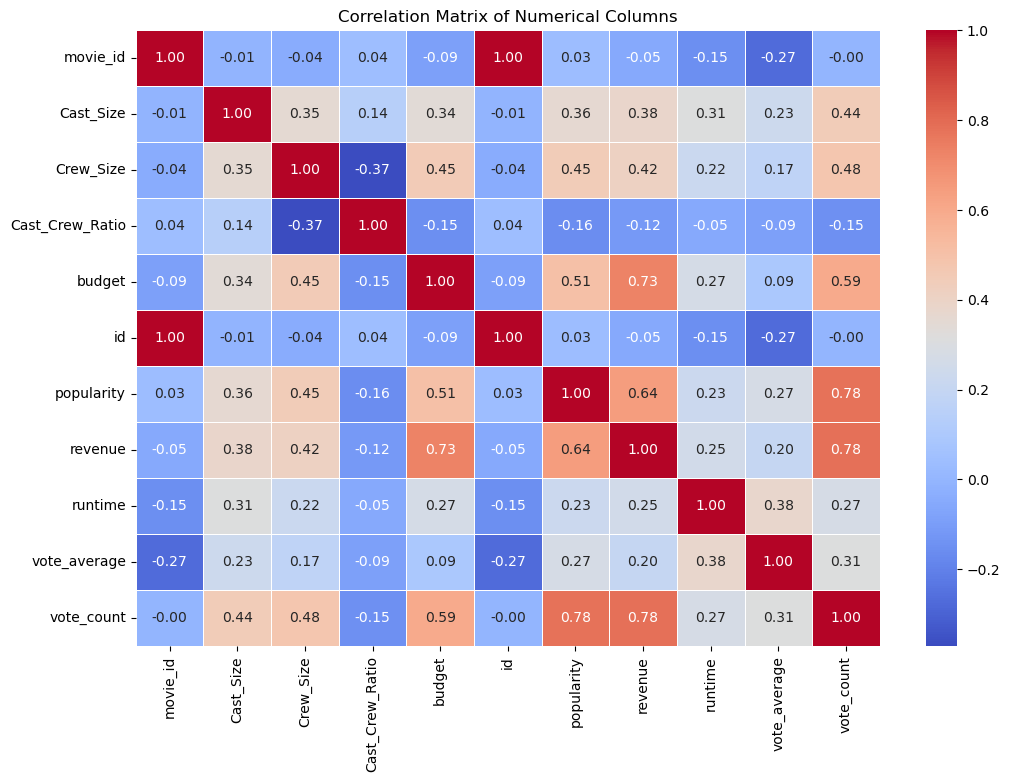

,movie_id,Cast_Size,Crew_Size,Cast_Crew_Ratio,budget,id,popularity,revenue,runtime,vote_average,vote_count
movie_id,1.000000,-0.011822,-0.039875,0.040880,-0.089377,1.000000,0.031202,-0.050425,-0.153536,-0.270595,-0.004128
Cast_Size,-0.011822,1.000000,0.352400,0.140790,0.339364,-0.011822,0.359520,0.380923,0.311265,0.230473,0.443242
Crew_Size,-0.039875,0.352400,1.000000,-0.370977,0.452587,-0.039875,0.447669,0.415923,0.219791,0.170989,0.475423
Cast_Crew_Ratio,0.040880,0.140790,-0.370977,1.000000,-0.154280,0.040880,-0.158992,-0.118329,-0.051587,-0.091085,-0.149030
budget,-0.089377,0.339364,0.452587,-0.154280,1.000000,-0.089377,0.505414,0.730823,0.269851,0.093146,0.593180
id,1.000000,-0.011822,-0.039875,0.040880,-0.089377,1.000000,0.031202,-0.050425,-0.153536,-0.270595,-0.004128
popularity,0.031202,0.359520,0.447669,-0.158992,0.505414,0.031202,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,-0.050425,0.380923,0.415923,-0.118329,0.730823,-0.050425,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,-0.153536,0.311265,0.219791,-0.051587,0.269851,-0.153536,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,-0.270595,0.230473,0.170989,-0.091085,0.093146,-0.270595,0.273952,0.197150,0.375046,1.000000,0.312997


In [5]:
# Select numerical columns for correlation analysis
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

# Display pairplot for the top correlated features (if identified later)
correlation_matrix

In [6]:
top_cast_flattened = []

for idx, row in df.iterrows():
    if isinstance(row['Top_Cast'], list):
        for person in row['Top_Cast']:
            if 'name' in person:
                top_cast_flattened.append({
                    'Name': person['name'],
                    'Popularity': row['popularity'],
                    'Revenue': row['revenue']})

# Convert the flattened data into a DataFrame
top_cast_df = pd.DataFrame(top_cast_flattened)

# Group by actor name and calculate average popularity and revenue
top_cast_summary = top_cast_df.groupby('Name').agg(
    Frequency=('Name', 'size'),
    Avg_Popularity=('Popularity', 'mean'),
    Avg_Revenue=('Revenue', 'mean')
).reset_index()

# Sort by frequency or revenue to find the most influential
top_cast_summary = top_cast_summary.sort_values(by='Avg_Revenue', ascending=False)
top_cast_summary.head()

,Name,Frequency,Avg_Popularity,Avg_Revenue
6468,Gloria Stuart,1,100.025899,1.845034e+09
15588,Ronda Rousey,1,102.322217,1.506249e+09
16026,Santino Fontana,1,165.125366,1.274219e+09
11490,Maia Wilson,1,165.125366,1.274219e+09
2459,Bérénice Marlohe,1,93.004993,1.108561e+09


In [7]:
adjusted_cast_flattened = []

for idx, row in df.iterrows():
    if isinstance(row['Top_Cast'], list):
        for person in row['Top_Cast']:
            if 'name' in person:
                adjusted_cast_flattened.append({
                    'Name': person['name'],
                    'Popularity': row['popularity'],
                    'Revenue': row['revenue']})


# Convert the flattened data into a DataFrame
adjusted_cast_df = pd.DataFrame(adjusted_cast_flattened)

# Group by actor name and calculate average popularity and revenue
adjusted_cast_summary = adjusted_cast_df.groupby('Name').agg(
    Frequency=('Name', 'size'),
    Avg_Popularity=('Popularity', 'mean'),
    Avg_Revenue=('Revenue', 'mean')
).reset_index()

# Sort by frequency or revenue to find the most influential
adjusted_cast_summary = adjusted_cast_summary.sort_values(by='Avg_Revenue', ascending=False)
adjusted_cast_summary.head()

,Name,Frequency,Avg_Popularity,Avg_Revenue
6468,Gloria Stuart,1,100.025899,1.845034e+09
15588,Ronda Rousey,1,102.322217,1.506249e+09
16026,Santino Fontana,1,165.125366,1.274219e+09
11490,Maia Wilson,1,165.125366,1.274219e+09
2459,Bérénice Marlohe,1,93.004993,1.108561e+09


In [8]:
adjusted_crew_flattened = []

for idx, row in df.iterrows():
    if isinstance(row['Adjusted_Crew'], list):
        for person in row['Adjusted_Crew']:
            if 'name' in person and 'department' in person:  # Ensure valid structure
                adjusted_crew_flattened.append({
                    'Name': person['name'],
                    'Department': person['department'],
                    'Popularity': row['popularity'],
                    'Revenue': row['revenue']})

# Convert the flattened data into a DataFrame
adjusted_crew_df = pd.DataFrame(adjusted_crew_flattened)

# Group by crew name and department, calculate average popularity and revenue
adjusted_crew_summary = adjusted_crew_df.groupby(['Name', 'Department']).agg(
    Frequency=('Name', 'size'),
    Avg_Popularity=('Popularity', 'mean'),
    Avg_Revenue=('Revenue', 'mean')
).reset_index()

# Sort by frequency or revenue to find the most influential
adjusted_crew_summary = adjusted_crew_summary.sort_values(by='Frequency', ascending=False)
adjusted_crew_summary.head()

,Name,Department,Frequency,Avg_Popularity,Avg_Revenue
4178,Avy Kaufman,Production,83,20.521463,8.038109e+07
37210,Mary Vernieu,Production,82,33.024840,8.744127e+07
13855,Deborah Aquila,Production,75,28.233287,8.779037e+07
23508,James Newton Howard,Sound,69,39.916740,2.263573e+08
21042,Hans Zimmer,Sound,68,61.017110,3.286194e+08


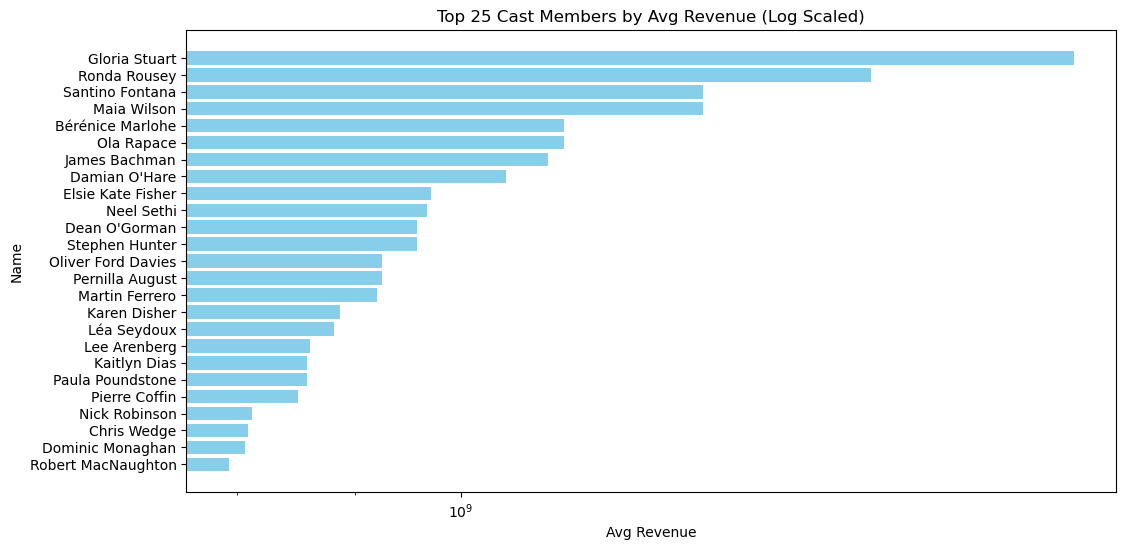

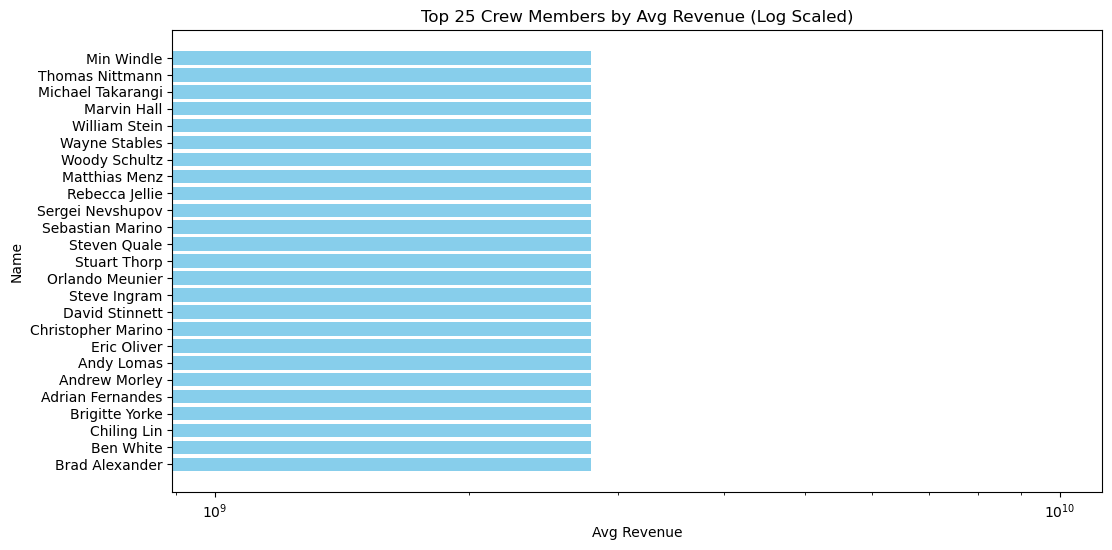

In [9]:
# Function to visualize top contributors with log scaling for better axis representation
def visualize_top_contributors_scaled(df, title, category_col='Name', value_col='Avg_Revenue', top_n=10):
    top_contributors = df.nlargest(top_n, value_col)
    
    # Bar plot with log-scaled x-axis
    plt.figure(figsize=(12, 6))
    plt.barh(top_contributors[category_col], top_contributors[value_col], color='skyblue')
    plt.xlabel(value_col.replace('_', ' '))
    plt.ylabel(category_col)
    plt.title(f"Top {top_n} {title} by {value_col.replace('_', ' ')} (Log Scaled)")
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.show()

# Visualize top 10 cast members by revenue (scaled)
visualize_top_contributors_scaled(top_cast_summary, "Cast Members", category_col='Name', value_col='Avg_Revenue', top_n=25)

# Visualize top 10 crew members by revenue (scaled)
visualize_top_contributors_scaled(adjusted_crew_summary, "Crew Members", category_col='Name', value_col='Avg_Revenue', top_n=25)

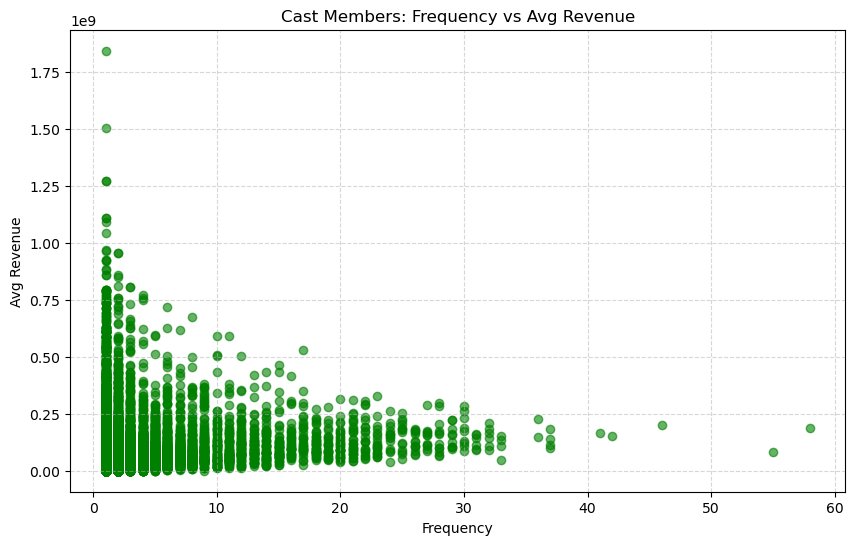

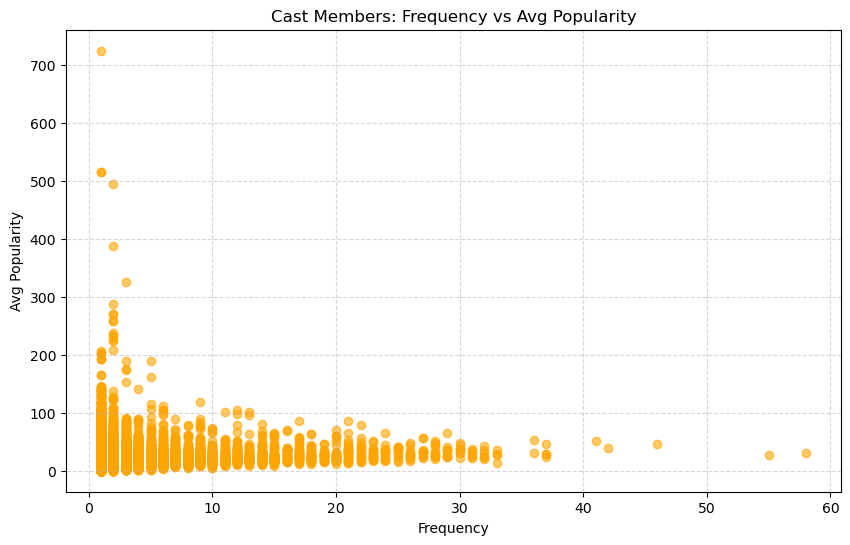

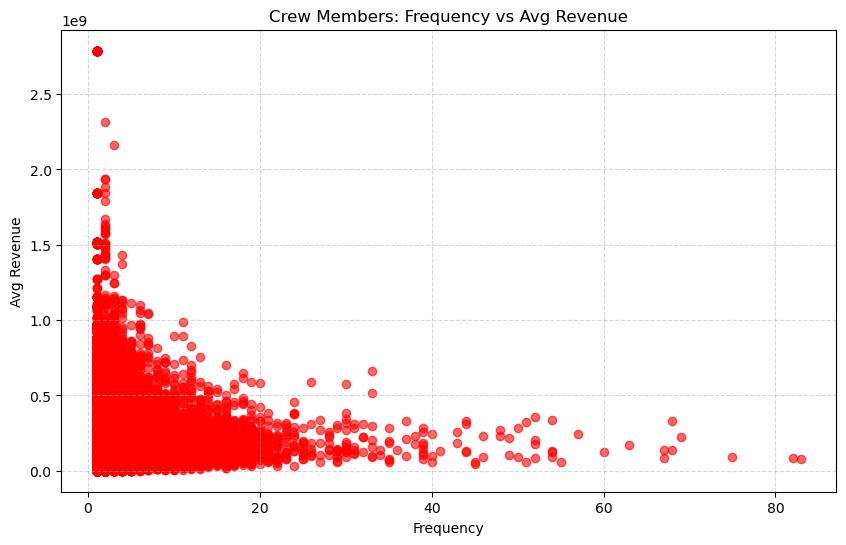

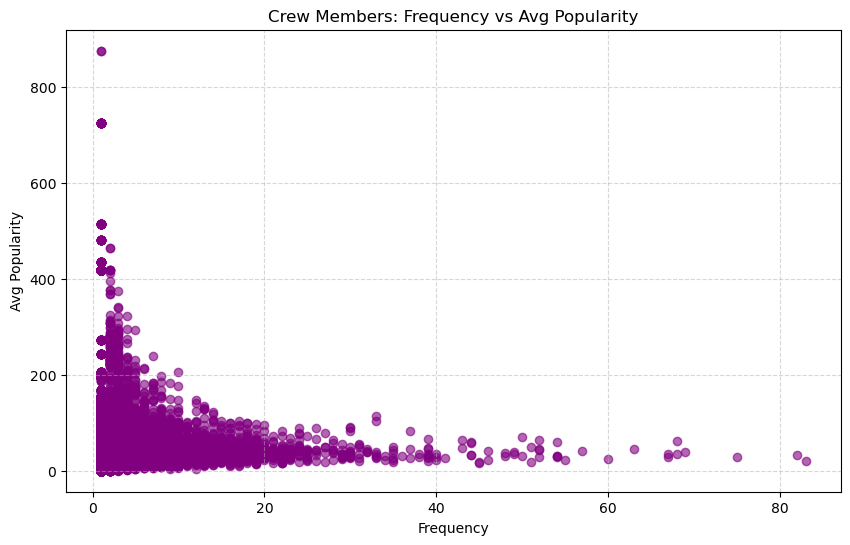

In [10]:
# Function to plot scatterplots for frequency vs popularity/revenue
def plot_frequency_vs_metric(df, title, category_col='Name', freq_col='Frequency', metric_col='Avg_Revenue', color='blue'):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[freq_col], df[metric_col], alpha=0.6, color=color)
    plt.title(f"{title}: {freq_col} vs {metric_col.replace('_', ' ')}")
    plt.xlabel(freq_col)
    plt.ylabel(metric_col.replace('_', ' '))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Plot for cast members: frequency vs revenue
plot_frequency_vs_metric(top_cast_summary, "Cast Members", freq_col='Frequency', metric_col='Avg_Revenue', color='green')

# Plot for cast members: frequency vs popularity
plot_frequency_vs_metric(top_cast_summary, "Cast Members", freq_col='Frequency', metric_col='Avg_Popularity', color='orange')

# Plot for crew members: frequency vs revenue
plot_frequency_vs_metric(adjusted_crew_summary, "Crew Members", freq_col='Frequency', metric_col='Avg_Revenue', color='red')

# Plot for crew members: frequency vs popularity
plot_frequency_vs_metric(adjusted_crew_summary, "Crew Members", freq_col='Frequency', metric_col='Avg_Popularity', color='purple')


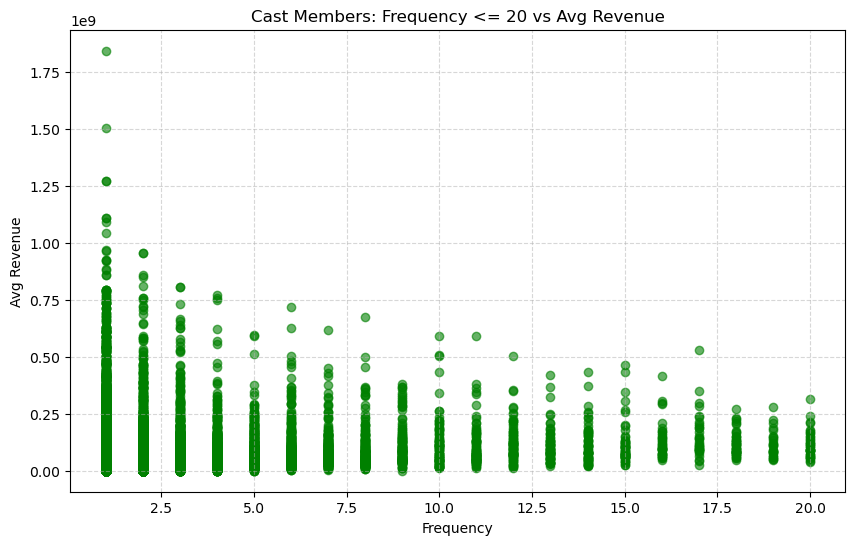

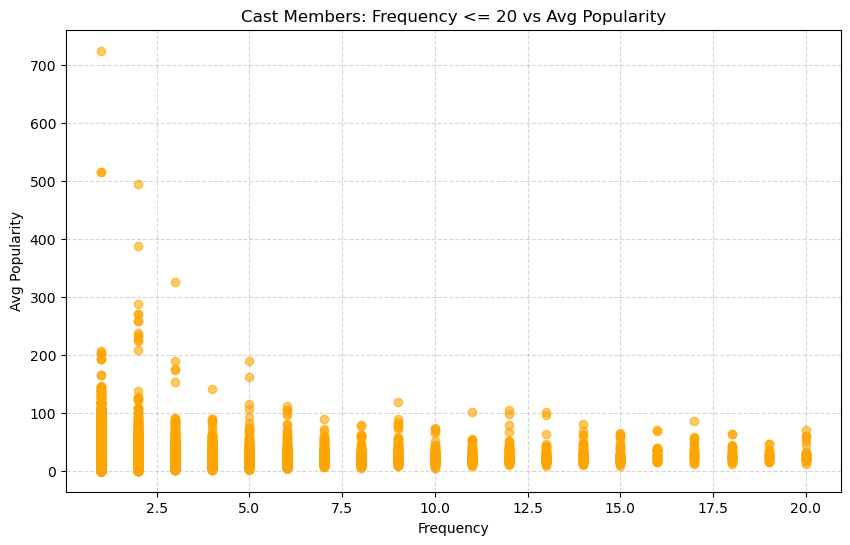

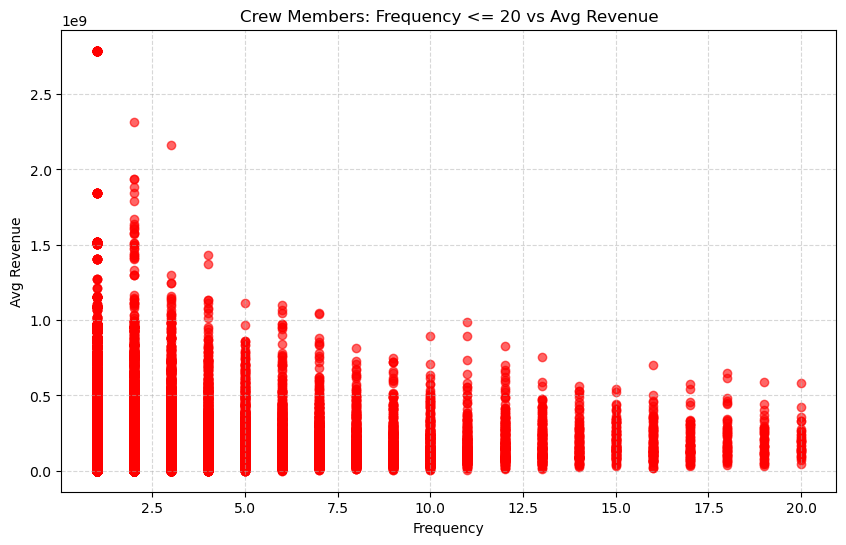

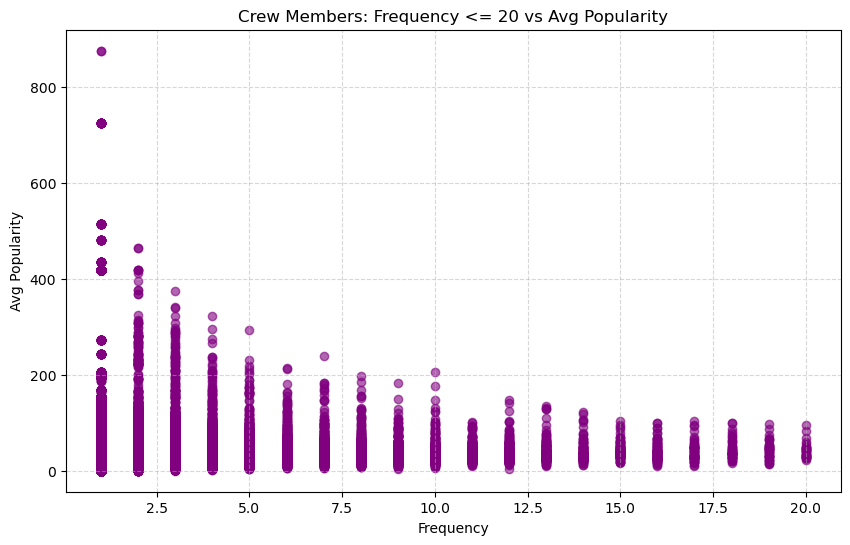

In [11]:
# Function to filter and scale scatterplots for specific frequency ranges
def plot_frequency_vs_metric_filtered(df, title, freq_col='Frequency', metric_col='Avg_Revenue', max_freq=20, color='blue'):
    filtered_df = df[df[freq_col] <= max_freq]
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_df[freq_col], filtered_df[metric_col], alpha=0.6, color=color)
    plt.title(f"{title}: {freq_col} <= {max_freq} vs {metric_col.replace('_', ' ')}")
    plt.xlabel(freq_col)
    plt.ylabel(metric_col.replace('_', ' '))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Plot for cast members: frequency <= 20 vs revenue
plot_frequency_vs_metric_filtered(top_cast_summary, "Cast Members", freq_col='Frequency', metric_col='Avg_Revenue', max_freq=20, color='green')

# Plot for cast members: frequency <= 20 vs popularity
plot_frequency_vs_metric_filtered(top_cast_summary, "Cast Members", freq_col='Frequency', metric_col='Avg_Popularity', max_freq=20, color='orange')

# Plot for crew members: frequency <= 20 vs revenue
plot_frequency_vs_metric_filtered(adjusted_crew_summary, "Crew Members", freq_col='Frequency', metric_col='Avg_Revenue', max_freq=20, color='red')

# Plot for crew members: frequency <= 20 vs popularity
plot_frequency_vs_metric_filtered(adjusted_crew_summary, "Crew Members", freq_col='Frequency', metric_col='Avg_Popularity', max_freq=20, color='purple')


In [12]:
# Filter cast members with Frequency < 20
cast_members_less_than_20 = top_cast_summary[top_cast_summary['Frequency'] < 20]

# Filter crew members with Frequency < 20
crew_members_less_than_20 = adjusted_crew_summary[adjusted_crew_summary['Frequency'] < 20]

# Save to CSV for review
cast_members_less_than_20.to_csv('Cast_Members_Less_Than_20.csv', index=False)
crew_members_less_than_20.to_csv('Crew_Members_Less_Than_20.csv', index=False)

# Print summaries
print("Cast Members with Frequency < 20")
print(cast_members_less_than_20)

print("Crew Members with Frequency < 20")
print(crew_members_less_than_20)

Cast Members with Frequency < 20
                        Name  Frequency  Avg_Popularity   Avg_Revenue
6468           Gloria Stuart          1      100.025899  1.845034e+09
15588           Ronda Rousey          1      102.322217  1.506249e+09
16026        Santino Fontana          1      165.125366  1.274219e+09
11490            Maia Wilson          1      165.125366  1.274219e+09
2459        Bérénice Marlohe          1       93.004993  1.108561e+09
...                      ...        ...             ...           ...
6712         Hannah Chalmers          1        2.122451  0.000000e+00
15219           Rizwan Manji          1        0.126304  0.000000e+00
3513          Colin McCredie          1        0.165367  0.000000e+00
11739         Marilyne Canto          1        1.410387  0.000000e+00
4608   Dick Anthony Williams          1        5.769822  0.000000e+00

[18804 rows x 4 columns]
Crew Members with Frequency < 20
                           Name         Department  Frequency  Avg_P

In [13]:
# Function to safely parse the genres column and extract genre names
def extract_genre_names(genres_str):
    try:
        genres = ast.literal_eval(genres_str)  # Convert string to list of dictionaries
        if isinstance(genres, list):
            return [genre['name'] for genre in genres if 'name' in genre]
    except:
        return []
    return []

# Apply the extraction function to the genres column
df['Genres_Extracted'] = df['genres'].apply(extract_genre_names)

# Flatten the genres into a long-format DataFrame
genres_flattened = []
for idx, row in df.iterrows():
    for genre in row['Genres_Extracted']:
        genres_flattened.append({
            'Genre': genre,
            'Revenue': row['revenue'],
            'Popularity': row['popularity']})
        
genres_df = pd.DataFrame(genres_flattened)

# Group by Genre and calculate metrics
genre_summary = genres_df.groupby('Genre').agg(
    Avg_Revenue=('Revenue', 'mean'),
    Avg_Popularity=('Popularity', 'mean'),
    Movie_Count=('Genre', 'size')
).reset_index()

C:\Users\bkhuu\AppData\Local\Temp\ipykernel_20792\372802947.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_revenue_genres, x='Avg_Revenue', y='Genre', palette='coolwarm')


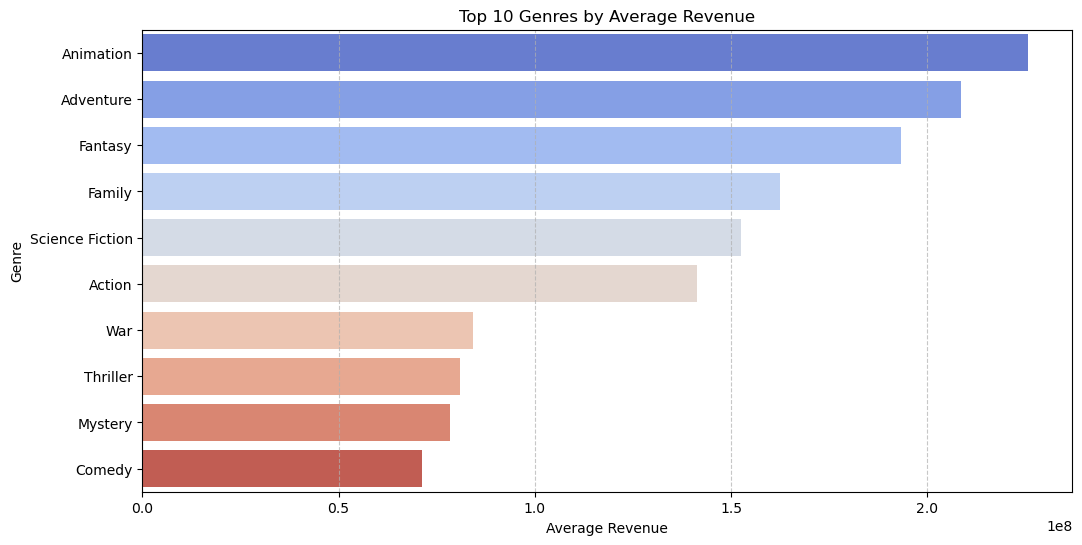

In [14]:
top_10_revenue_genres = genre_summary.sort_values(by='Avg_Revenue', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_revenue_genres, x='Avg_Revenue', y='Genre', palette='coolwarm')
plt.title('Top 10 Genres by Average Revenue')
plt.xlabel('Average Revenue')
plt.ylabel('Genre')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

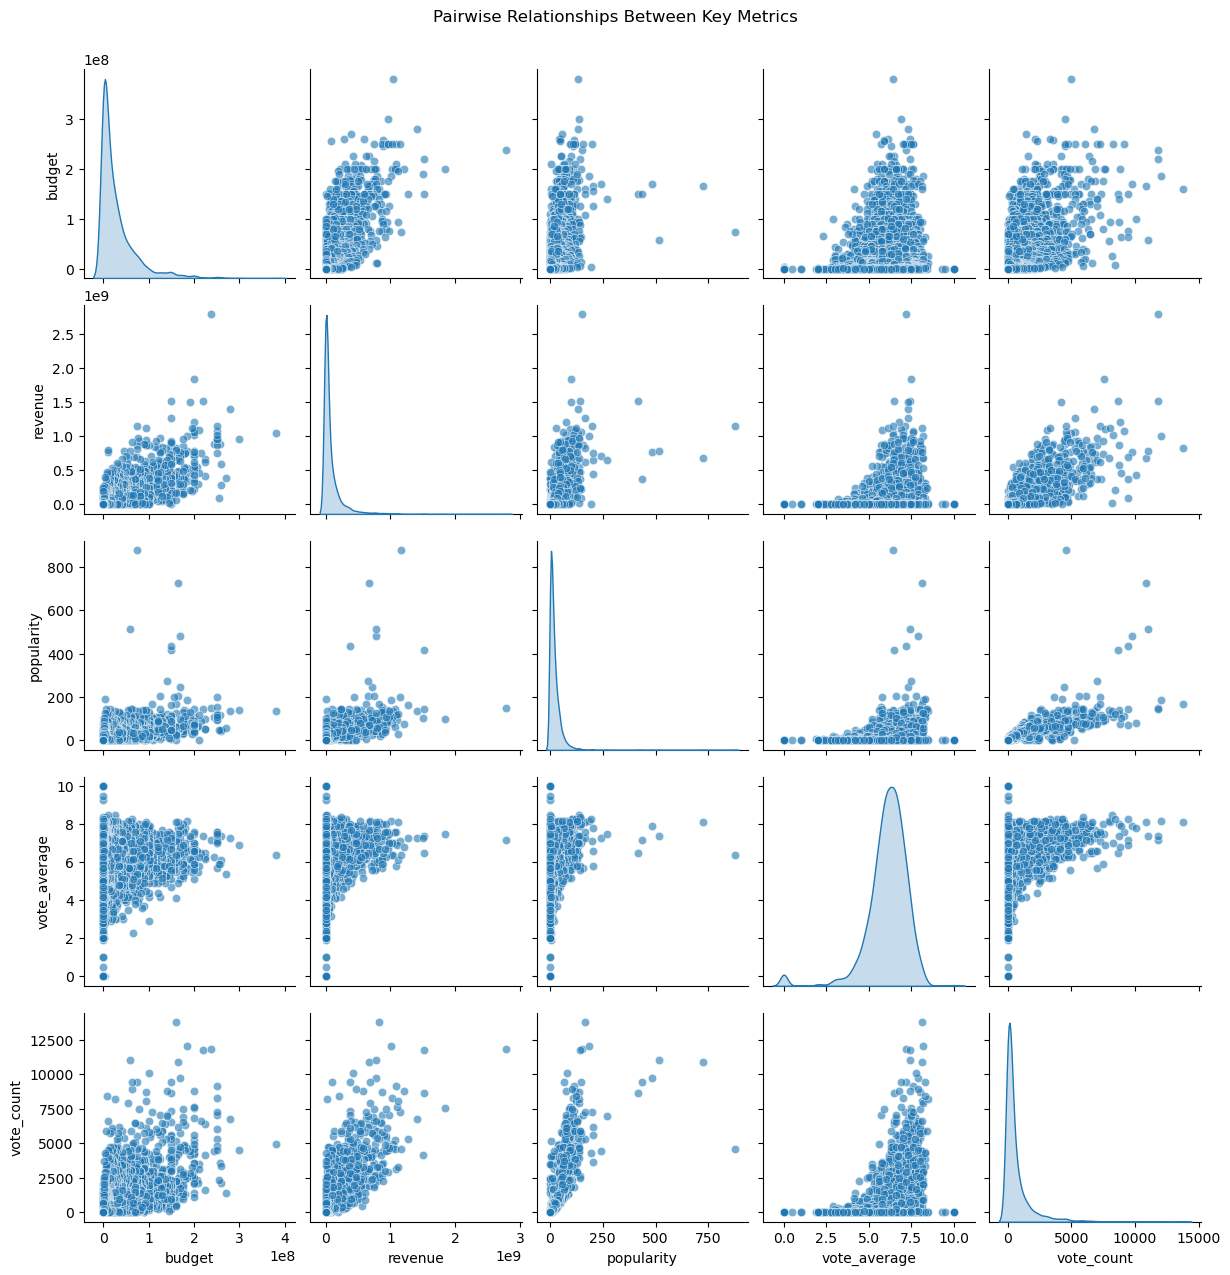

In [15]:
def plot_pairwise_relationships(df, selected_columns, title):
    sns.pairplot(df[selected_columns], diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.suptitle(title, y=1.02)  # Add title above the plots
    plt.show()

# Select numerical columns of interest for pairwise relationships
numerical_columns = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count']

# Ensure the selected columns exist in your dataset
available_columns = [col for col in numerical_columns if col in df.columns]

# Plot pairwise relationships if valid columns exist
if available_columns:
    plot_pairwise_relationships(df, available_columns, "Pairwise Relationships Between Key Metrics")
else:
    print("None of the selected columns are available in the dataset.")

In [16]:
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Identify outliers for key metrics
outliers = {}
key_metrics = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count']

for metric in key_metrics:
    if metric in df.columns:
        outliers[metric] = identify_outliers(df, metric)

# Combine outliers into a single DataFrame for review
all_outliers = pd.concat(outliers.values(), keys=outliers.keys(), names=['Metric', 'Index'])
all_outliers

movie_id                                   title_x  \
Metric     Index                                                       
budget     0         19995                                    Avatar   
           1           285  Pirates of the Caribbean: At World's End   
           2        206647                                   Spectre   
           3         49026                     The Dark Knight Rises   
           4         49529                               John Carter   
...                    ...                                       ...   
vote_count 4300        500                            Reservoir Dogs   
           4302        429            The Good, the Bad and the Ugly   
           4333       1366                                     Rocky   
           4337        103                               Taxi Driver   
           4602        389                              12 Angry Men   

                                                               cast  \
Metric     Index                                                      
budget     0      [{'cast_id': 242, 'character': 'Jake Sully', '...   
           1      [{'cast_id': 4, 'character': 'Captain Jack Spa...   
           2      [{'cast_id': 1, 'character': 'James Bond', 'cr...   
           3      [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...   
           4      [{'cast_id': 5, 'character': 'John Carter', 'c...   
...                                                             ...   
vote_count 4300   [{'cast_id': 20, 'character': 'Mr. White/Larry...   
           4302   [{'cast_id': 6, 'character': 'Tuco', 'credit_i...   
           4333   [{'cast_id': 16, 'character': 'Rocky Balboa', ...   
           4337   [{'cast_id': 5, 'character': 'Travis Bickle', ...   
           4602   [{'cast_id': 29, 'character': 'Juror 8', 'cred...   

                                                               crew  \
Metric     Index                                                      
budget     0      [{'credit_id': '52fe48009251416c750aca23', 'de...   
           1      [{'credit_id': '52fe4232c3a36847f800b579', 'de...   
           2      [{'credit_id': '54805967c3a36829b5002c41', 'de...   
           3      [{'credit_id': '52fe4781c3a36847f81398c3', 'de...   
           4      [{'credit_id': '52fe479ac3a36847f813eaa3', 'de...   
...                                                             ...   
vote_count 4300   [{'credit_id': '52fe424ac3a36847f8012cb9', 'de...   
           4302   [{'credit_id': '575aee00c3a3682d10000281', 'de...   
           4333   [{'credit_id': '579948e9c3a36874e9007b0b', 'de...   
           4337   [{'credit_id': '52fe4218c3a36847f8003803', 'de...   
           4602   [{'credit_id': '52fe423dc3a36847f800ec55', 'de...   

                                                      Adjusted_Cast  \
Metric     Index                                                      
budget     0      [{'id': 65731, 'name': 'Sam Worthington', 'gen...   
           1      [{'id': 85, 'name': 'Johnny Depp', 'gender': 2...   
           2      [{'id': 8784, 'name': 'Daniel Craig', 'gender'...   
           3      [{'id': 3894, 'name': 'Christian Bale', 'gende...   
           4      [{'id': 60900, 'name': 'Taylor Kitsch', 'gende...   
...                                                             ...   
vote_count 4300   [{'id': 1037, 'name': 'Harvey Keitel', 'gender...   
           4302   [{'id': 3265, 'name': 'Eli Wallach', 'gender':...   
           4333   [{'id': 16483, 'name': 'Sylvester Stallone', '...   
           4337   [{'id': 380, 'name': 'Robert De Niro', 'gender...   
           4602   [{'id': 4958, 'name': 'Henry Fonda', 'gender':...   

                  Cast_Size  \
Metric     Index              
budget     0             83   
           1             34   
           2             83   
           3            158   
           4             27   
...                     ...   
vote_count 4300          15   
           4302          40   

c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24464 (\N{CJK UNIFIED IDEOGRAPH-5F90}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24070 (\N{CJK UNIFIED IDEOGRAPH-5E06}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


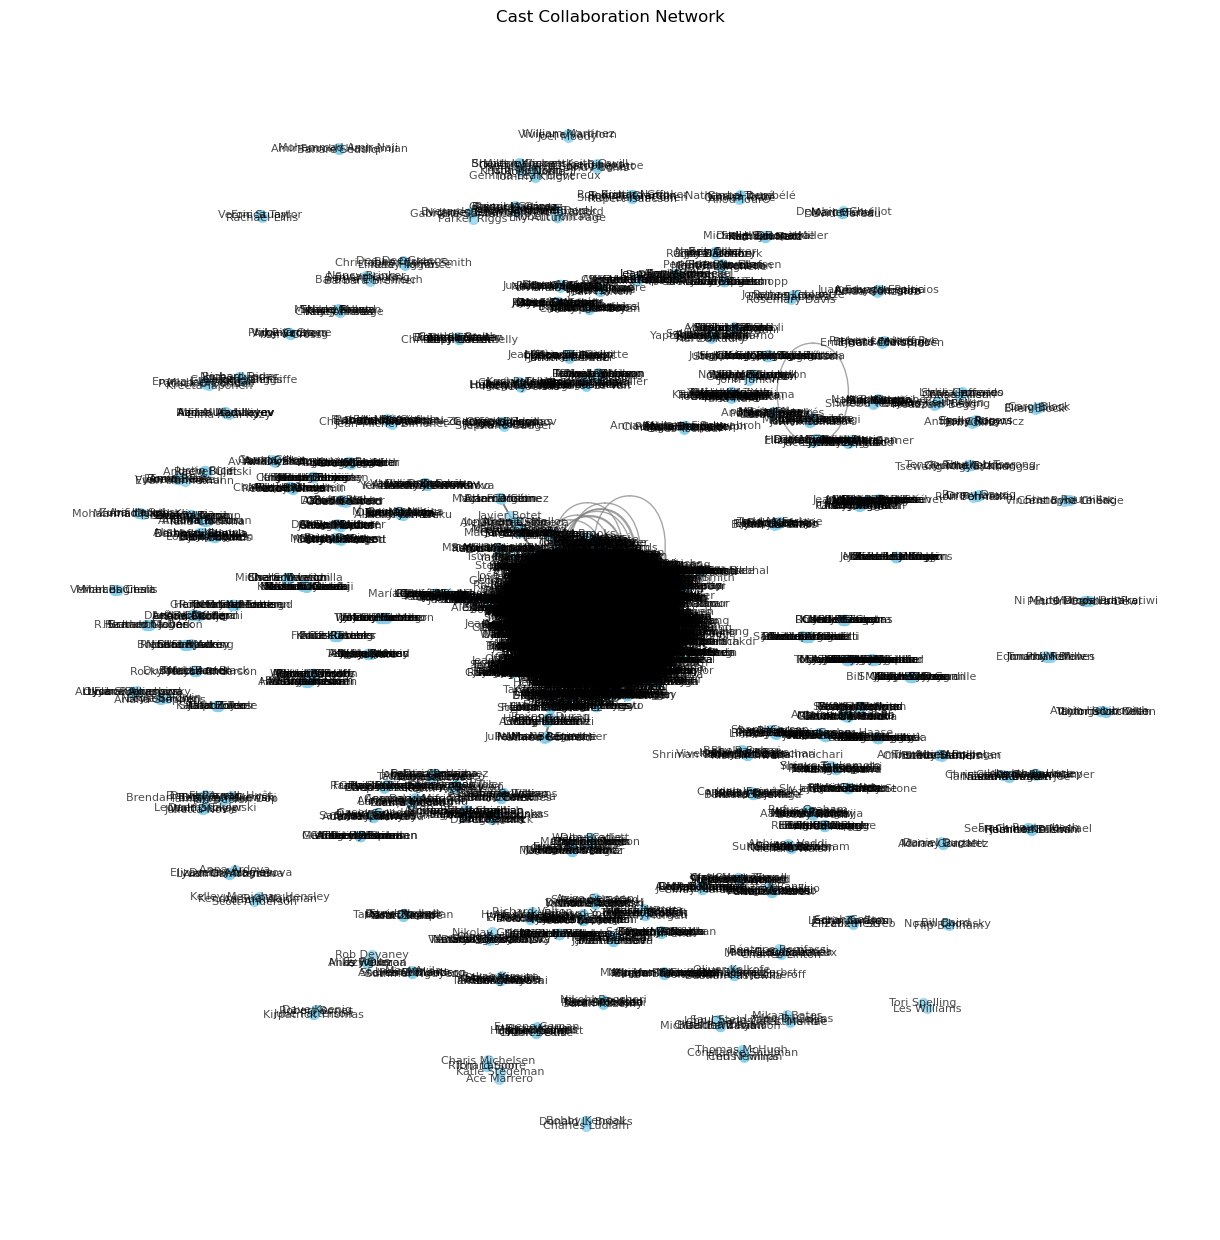

Top 10 Central Cast Members:
Samuel L. Jackson: 0.0238
Robert De Niro: 0.0222
Morgan Freeman: 0.0189
Bruce Willis: 0.0177
Matt Damon: 0.0165
Nicolas Cage: 0.0164
Alec Baldwin: 0.0158
Johnny Depp: 0.0151
Brad Pitt: 0.0149
Owen Wilson: 0.0146


In [17]:
# Example dataset structure (adjust based on your data):
# data['Top_Cast'] should contain a list of cast members for each movie.

# Step 1: Create the graph
G = nx.Graph()

# Iterate through each movie to extract collaborations
for _, row in df.iterrows():
    if isinstance(row['Top_Cast'], list):
        # Generate all pairs of cast members for the movie
        cast_pairs = combinations([person['name'] for person in row['Top_Cast']], 2)
        for pair in cast_pairs:
            # Add an edge for each pair
            if G.has_edge(*pair):
                # Increment the weight if the edge already exists
                G[pair[0]][pair[1]]['weight'] += 1
            else:
                # Add the edge with an initial weight
                G.add_edge(pair[0], pair[1], weight=1)

# Step 2: Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=50,
    node_color="skyblue",
    font_size=8,
    edge_color="gray",
    alpha=0.7
)
plt.title("Cast Collaboration Network")
plt.show()

# Step 3: Analyze the network
# Calculate degree centrality (importance of nodes)
centrality = nx.degree_centrality(G)
top_central_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Display the top 10 central cast members
print("Top 10 Central Cast Members:")
for name, centrality_score in top_central_nodes:
    print(f"{name}: {centrality_score:.4f}")


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

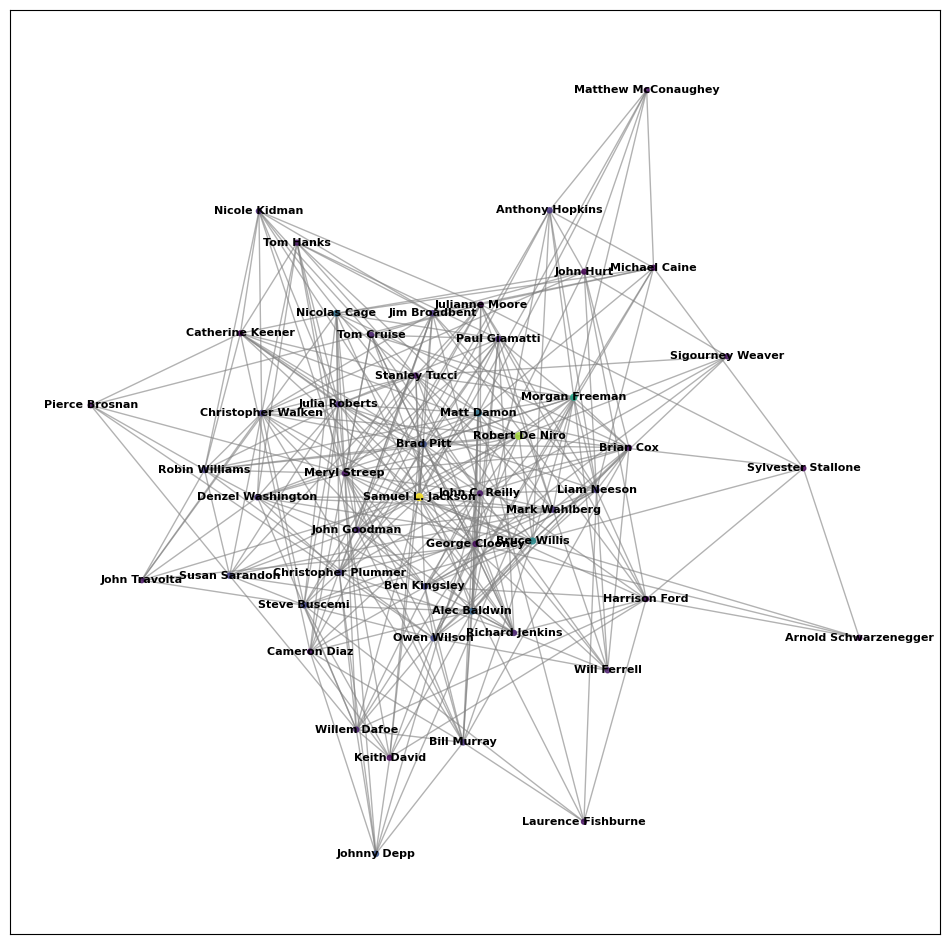

In [18]:
# Filter graph to include only the top central nodes with centrality scores
def filter_top_nodes_with_centrality(graph, top_n=50):
    centrality = nx.degree_centrality(graph)
    top_nodes = sorted(centrality, key=centrality.get, reverse=True)[:top_n]
    subgraph = graph.subgraph(top_nodes)
    return subgraph, {node: centrality[node] for node in top_nodes}

# Create a filtered subgraph with the top 50 nodes and their centrality scores
filtered_graph, centrality_scores = filter_top_nodes_with_centrality(G, top_n=50)

# Plot the filtered graph with centrality scores
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(filtered_graph, seed=42)  # Layout for better spacing
node_sizes = [centrality_scores[node] * 1000 for node in filtered_graph.nodes()]  # Scale node sizes by centrality
node_colors = [centrality_scores[node] for node in filtered_graph.nodes()]  # Color nodes by centrality

# Draw nodes, edges, and labels
nx.draw_networkx_nodes(filtered_graph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(filtered_graph, pos, edge_color="gray", alpha=0.6)
nx.draw_networkx_labels(filtered_graph, pos, font_size=8, font_color="black", font_weight="bold")

# Add a colorbar for centrality scores
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
plt.colorbar(sm, label="Centrality Score")

plt.title("Filtered Cast Collaboration Network (Top 50 Central Nodes with Centrality Scores)")
plt.axis("off")
plt.show()